In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc


In [2]:
epochs=15


In [3]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values (0 to 1)
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Flatten images (28x28 → 784 features)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# Define anomaly: Digit 9 = anomaly, 0–8 = normal
normal_idx = y_train != 9
x_train_normal = x_train[normal_idx]

x_test_normal = x_test[y_test != 9]
x_test_anomaly = x_test[y_test == 9]

# Combine test data
x_test_combined = np.concatenate([x_test_normal, x_test_anomaly])
y_test_combined = np.concatenate([
    np.zeros(len(x_test_normal)),   # Normal = 0
    np.ones(len(x_test_anomaly))    # Anomaly = 1
])

print("Training Normal Shape:", x_train_normal.shape)
print("Test Combined Shape:", x_test_combined.shape)


Training Normal Shape: (54051, 784)
Test Combined Shape: (10000, 784)


In [6]:
latent_dim = 16

# Encoder
inputs = keras.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Reparameterization Trick (SAFE VERSION)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_input = keras.Input(shape=(latent_dim,))
d = layers.Dense(128, activation="relu")(decoder_input)
d = layers.Dense(256, activation="relu")(d)
decoder_output = layers.Dense(784, activation="sigmoid")(d)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

# VAE Output
outputs = decoder(z)

# Define VAE model (Functional API)
vae = keras.Model(inputs, outputs, name="vae")


In [7]:
# Reconstruction Loss (using MSE - more stable than BCE for MNIST)
reconstruction_loss = tf.reduce_mean(
    tf.reduce_sum(tf.square(inputs - outputs), axis=1)
)

# KL Divergence Loss
kl_loss = -0.5 * tf.reduce_mean(
    tf.reduce_sum(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
        axis=1
    )
)

# Total VAE Loss
vae_loss = reconstruction_loss + kl_loss

# Add loss properly
vae.add_loss(vae_loss)

# Compile
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

vae.summary()


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 256)                  200960    ['input_3[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 128)                  32896     ['dense_5[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 16)                   2064      ['dense_6[0][0]']             
                                                                                               

In [8]:
history = vae.fit(
    x_train_normal,
    x_train_normal,
    epochs=15,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)


Epoch 1/15
381/381 [==============================] - 10s 18ms/step - loss: 51.3370 - val_loss: 41.7257
Epoch 2/15
381/381 [==============================] - 7s 19ms/step - loss: 38.6135 - val_loss: 36.3601
Epoch 3/15
381/381 [==============================] - 6s 16ms/step - loss: 35.1968 - val_loss: 34.1395
Epoch 4/15
381/381 [==============================] - 6s 17ms/step - loss: 33.6217 - val_loss: 33.0106
Epoch 5/15
381/381 [==============================] - 7s 17ms/step - loss: 32.6024 - val_loss: 32.1259
Epoch 6/15
381/381 [==============================] - 6s 17ms/step - loss: 31.9430 - val_loss: 31.3804
Epoch 7/15
381/381 [==============================] - 6s 17ms/step - loss: 31.3819 - val_loss: 31.1114
Epoch 8/15
381/381 [==============================] - 6s 17ms/step - loss: 30.9790 - val_loss: 30.6817
Epoch 9/15
381/381 [==============================] - 6s 16ms/step - loss: 30.6213 - val_loss: 30.1981
Epoch 10/15
381/381 [==============================] - 7s 17ms/step - lo

In [9]:
print(type(vae))

<class 'keras.src.engine.functional.Functional'>


In [10]:
# Get VAE reconstructions
#vae_reconstructions = vae.predict(x_test_combined)

# Direct forward pass (bypasses broken predict wrapper)
vae_reconstructions = vae(x_test_combined, training=False).numpy()

# Calculate reconstruction error (MSE per sample)
vae_errors = np.mean(np.square(x_test_combined - vae_reconstructions), axis=1)

print("Reconstruction error calculated!")
print("Sample errors:", vae_errors[:10])


Reconstruction error calculated!
Sample errors: [0.01480477 0.0275795  0.00609045 0.01540454 0.01914495 0.00431256
 0.04025499 0.05768408 0.01434368 0.03788473]


In [12]:
# Build Baseline Autoencoder
input_ae = keras.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(input_ae)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
output_ae = layers.Dense(784, activation="sigmoid")(x)

autoencoder = keras.Model(input_ae, output_ae)
autoencoder.compile(optimizer="adam", loss="mse")

# Train Autoencoder
autoencoder.fit(
    x_train_normal,
    x_train_normal,
    epochs=15,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)


Epoch 1/15
381/381 [==============================] - 7s 14ms/step - loss: 0.0399 - val_loss: 0.0180
Epoch 2/15
381/381 [==============================] - 6s 15ms/step - loss: 0.0141 - val_loss: 0.0124
Epoch 3/15
381/381 [==============================] - 6s 15ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 4/15
381/381 [==============================] - 6s 15ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 5/15
381/381 [==============================] - 6s 15ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 6/15
381/381 [==============================] - 5s 13ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 7/15
381/381 [==============================] - 5s 14ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 8/15
381/381 [==============================] - 6s 15ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 9/15
381/381 [==============================] - 6s 15ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 10/15
381/381 [==============================] - 6s 15ms/step - loss: 0.0055 - val_lo

In [13]:
# Autoencoder reconstructions
ae_reconstructions = autoencoder.predict(x_test_combined)

# Reconstruction error
ae_errors = np.mean(np.square(x_test_combined - ae_reconstructions), axis=1)

print("Autoencoder reconstruction error calculated!")


313/313 [==============================] - 2s 4ms/step
Autoencoder reconstruction error calculated!


VAE AUC Score: 0.675559107174568
Autoencoder AUC Score: 0.48828478296598543


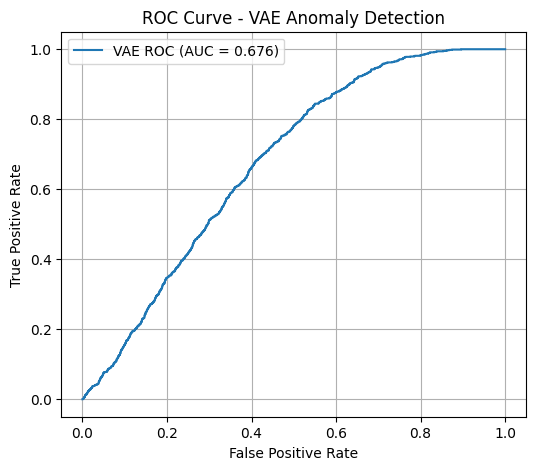

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# AUC Scores
vae_auc = roc_auc_score(y_test_combined, vae_errors)
ae_auc = roc_auc_score(y_test_combined, ae_errors)

print("VAE AUC Score:", vae_auc)
print("Autoencoder AUC Score:", ae_auc)

# ROC Curve for VAE
fpr, tpr, _ = roc_curve(y_test_combined, vae_errors)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"VAE ROC (AUC = {vae_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - VAE Anomaly Detection")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Create encoder model to extract latent mean
encoder = keras.Model(inputs, z_mean)

# Get latent vectors
z_test = encoder.predict(x_test_combined)

# Separate normal and anomaly latent representations
normal_latent = z_test[y_test_combined == 0]
anomaly_latent = z_test[y_test_combined == 1]

# Compute statistics
print("Latent Space Statistics:")
print("Mean (μ) - Normal Data:", np.mean(normal_latent))
print("Variance (σ²) - Normal Data:", np.var(normal_latent))
print("Mean (μ) - Anomaly Data:", np.mean(anomaly_latent))
print("Variance (σ²) - Anomaly Data:", np.var(anomaly_latent))


313/313 [==============================] - 1s 3ms/step
Latent Space Statistics:
Mean (μ) - Normal Data: -0.008011595
Variance (σ²) - Normal Data: 0.5047413
Mean (μ) - Anomaly Data: 0.043612443
Variance (σ²) - Anomaly Data: 0.38737434


In [18]:
print(type(vae))


<class 'keras.src.engine.functional.Functional'>


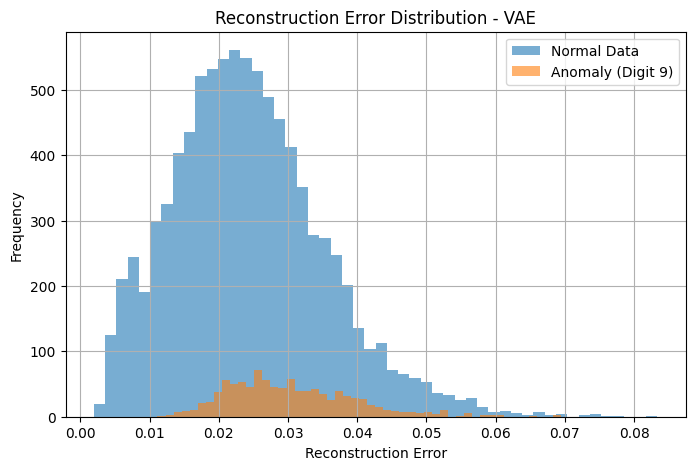

In [19]:
# Reconstruction Error Distribution
plt.figure(figsize=(8,5))

plt.hist(vae_errors[y_test_combined == 0], bins=50, alpha=0.6, label="Normal Data")
plt.hist(vae_errors[y_test_combined == 1], bins=50, alpha=0.6, label="Anomaly (Digit 9)")

plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution - VAE")
plt.legend()
plt.grid(True)
plt.show()
